In [1]:
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
import os
from helpers import *
from preprocessing import *
import pickle

In [2]:
#x_train, x_test, y_train, train_ids, test_ids=load_csv_data("data")

In [3]:
DATA_FOLDER = 'data/'

In [4]:
try:
    with open(DATA_FOLDER + 'x_train.pickle', 'rb') as f:
        x_train = pickle.load(f)
    with open(DATA_FOLDER + 'x_test.pickle', 'rb') as f:
        x_test = pickle.load(f)
    with open(DATA_FOLDER + 'y_train.pickle', 'rb') as f:
        y_train = pickle.load(f)
    with open(DATA_FOLDER + 'test_ids.pickle', 'rb') as f:
        test_ids = pickle.load(f)
    with open(DATA_FOLDER + 'names_map.pickle', 'rb') as f:
        names_map = pickle.load(f)
except:
    x_train, x_test, y_train, train_ids, test_ids = load_csv_data(DATA_FOLDER, sub_sample=False)

    names = np.genfromtxt(DATA_FOLDER + 'x_train.csv', delimiter=",", dtype=str, max_rows=1)
    names = np.delete(names, 0)
    names_map = {}
    for i in range(len(names)):
        names_map[names[i]] = i

    with open(DATA_FOLDER + 'x_train.pickle', 'wb') as f:
        pickle.dump(x_train, f)

    with open(DATA_FOLDER + 'x_test.pickle', 'wb') as f:
        pickle.dump(x_test, f)

    with open(DATA_FOLDER + 'y_train.pickle', 'wb') as f:
        pickle.dump(y_train, f)

    with open(DATA_FOLDER + 'test_ids.pickle', 'wb') as f:
        pickle.dump(test_ids, f)
    
    with open(DATA_FOLDER + 'names_map.pickle', 'wb') as f:
        pickle.dump(names_map, f)

## Preprocessing and Scalings

In [5]:
DATA_FOLDER = 'data/'

In [6]:
names = np.genfromtxt(DATA_FOLDER + 'x_train.csv', delimiter=",", dtype=str, max_rows=1)
names = np.delete(names, 0)
names_map = {}
for i in range(len(names)):
    names_map[names[i]] = i

In [7]:
y_train = np.where(y_train == -1, 0, y_train)
x_tr = x_train.copy()
y_tr = y_train.copy()


In [8]:
x_tr, x_val, y_tr, y_val = split_data(x_tr, y_tr, 0.8, seed=1)

In [9]:
#clean the data and return the cleaned dataset, the y values, the mean and median dictionaries to use to clean other sets (test set for example)
x_tr_clean, y_tr_clean, mean_dico, median_dico, interesting_features = clean_data(names_map, x_tr, y_tr, is_y=True, is_train_data=True)
x_val_clean, y_val_clean, _, _, _ = clean_data(names_map, x_val, y_val, is_y=True, is_train_data=False, mean_dico=mean_dico, median_dico=median_dico)

#if we don't have the y values, we use is_y=False.
x_test_clean, _, _, _, _ = clean_data(names_map, x_test, y_raw=None, is_y=False, is_train_data=False, mean_dico=mean_dico, median_dico=median_dico)

In [10]:
np.where(y_tr_clean==1)[0].shape[0]/np.where(y_tr_clean==0)[0].shape[0]

0.09745982374287196

In [11]:
np.where(y_val_clean==1)[0].shape[0]/np.where(y_val_clean==0)[0].shape[0]

0.09443999733173238

## Feature selection

We chose some initial features by reading the report and assessing how they seemed relevant for our predictions.

In [12]:
interesting_features_indexes=np.array([names_map[feature] for feature in interesting_features])

In [13]:
X_train=x_tr_clean[:,interesting_features_indexes]
X_validation = x_val_clean[:,interesting_features_indexes]
X_test=x_test_clean[:,interesting_features_indexes]

#### Build polynomial expension and interaction features

In [14]:
max_degree=5

X_train_poly,features_names=build_poly_expansion_with_interaction_features(X_train,features_names=interesting_features,max_degree=max_degree)
X_val_poly,_=build_poly_expansion_with_interaction_features(X_validation,features_names=interesting_features,max_degree=max_degree)
X_test_poly,_=build_poly_expansion_with_interaction_features(X_test,features_names=interesting_features,max_degree=max_degree)

In [15]:
X_train_poly, train_mean_poly, train_std_poly=scale_data(X_train_poly,is_train_data=True)
X_val_poly, _, _=scale_data(X_val_poly,is_train_data=False,train_mean=train_mean_poly,train_std=train_std_poly)
X_test_poly,_,_=scale_data(X_test_poly,is_train_data=False,train_mean=train_mean_poly,train_std=train_std_poly)

#### By correlation with the output

#### Again selecting features with correlation with the outcome y

In [16]:
correlations = np.corrcoef(np.hstack([X_train_poly, y_tr_clean.reshape(-1,1)]), rowvar=False)[:, X_train_poly.shape[1]][:-1]

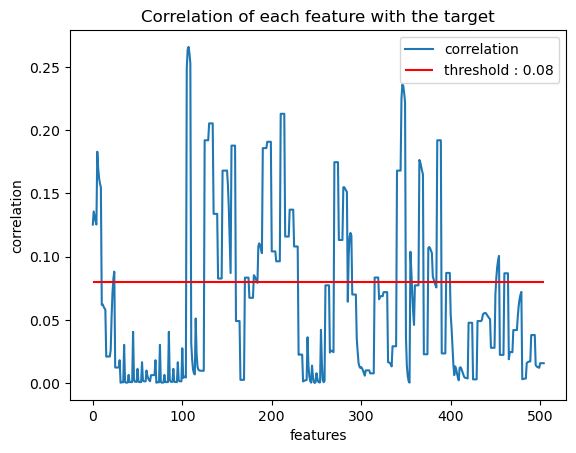

In [17]:
threshold = 0.08
plt.plot(np.abs(correlations))
plt.hlines(y=threshold, xmin=0, xmax=len(correlations) - 1, color='r')
plt.xlabel('features')
plt.ylabel('correlation')
plt.title('Correlation of each feature with the target')
plt.legend(['correlation', f"threshold : {threshold}"])
plt.show()

In [18]:
high_corr_indexes = np.where(correlations > threshold)[0]

In [19]:
high_corr_indexes.shape

(36,)

In [20]:
X_train_corr = X_train_poly[:, high_corr_indexes]
X_val_corr = X_val_poly[:, high_corr_indexes]

#### Ridge regression

(0.44483985765124556, 0.04414621225498852, 0.08032128514056225)


D:\Projects\EPFL\ML-WhAI\ml-project-1-whai\implementations.py:445: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * precision * recall / (precision + recall)
D:\Projects\EPFL\ML-WhAI\ml-project-1-whai\implementations.py:443: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


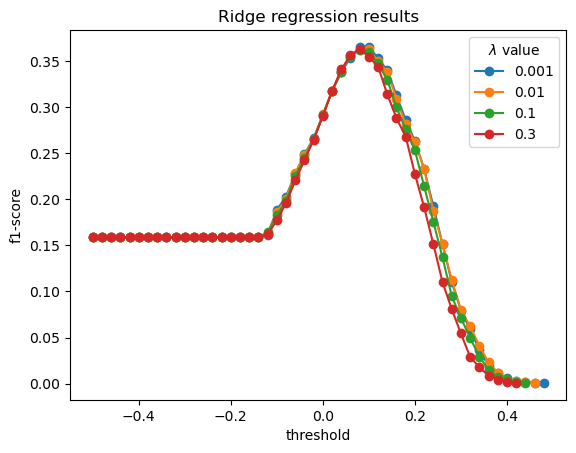

In [22]:
w_opt,loss=ridge_regression(y_tr_clean,X_train_corr,lambda_=0.01)
print(compute_scores_linear_model(X_val_corr,w_opt,y=y_val_clean,threshold=0.3,apply_sigmoid=False))
thr_l=np.arange(-0.5,0.7,0.02)
for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_tr_clean,X_train_corr,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_corr,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value")
plt.title("Ridge regression results")
plt.show()

(0.08629070352141649, 1.0, 0.15887221209145744)



KeyboardInterrupt



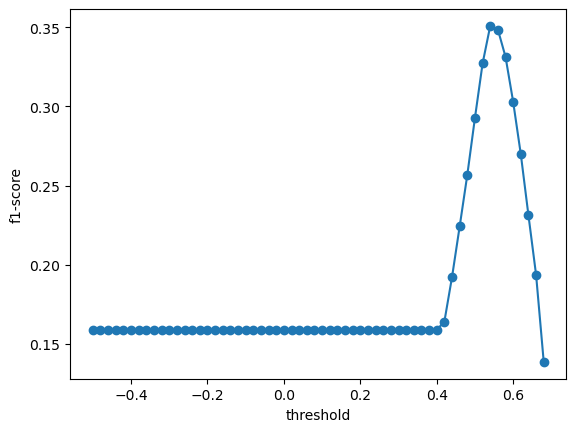

In [24]:
w_opt, loss = reg_logistic_regression(y_tr_clean,X_train_corr,lambda_=0.01, initial_w=np.zeros(X_train_corr.shape[1]),max_iters=50,gamma=0.01)
print(compute_scores_logistic_regression(X_val_corr,w_opt,y=y_val_clean,threshold=0.3))
thr_l=np.arange(-0.5,0.7,0.02)
for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss = reg_logistic_regression(y_tr_clean,X_train_corr,lambda_=lambda_, initial_w=np.zeros(X_train_corr.shape[1]),max_iters=50,gamma=0.01)
    f1_scores=[compute_scores_logistic_regression(X_val_corr,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value")
plt.title("Ridge regression results")
plt.show()

(0.08629070352141649, 1.0, 0.15887221209145744)


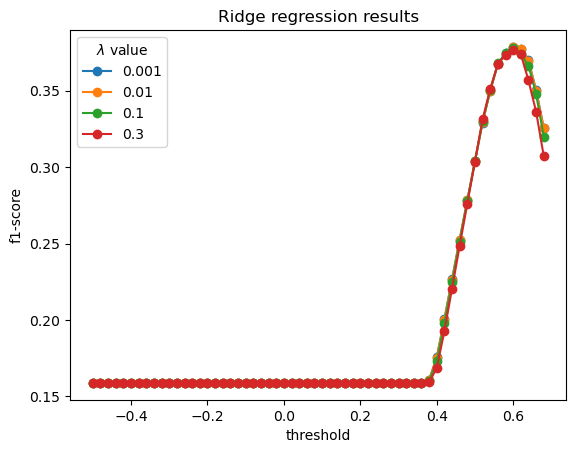

In [25]:
w_opt, loss = reg_logistic_regression(y_tr_clean,X_train_poly,lambda_=0.01, initial_w=np.zeros(X_train_poly.shape[1]),max_iters=50,gamma=0.01)
print(compute_scores_logistic_regression(X_val_poly,w_opt,y=y_val_clean,threshold=0.3))
thr_l=np.arange(-0.5,0.7,0.02)
for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss = reg_logistic_regression(y_tr_clean,X_train_poly,lambda_=lambda_, initial_w=np.zeros(X_train_poly.shape[1]),max_iters=50,gamma=0.01)
    f1_scores=[compute_scores_logistic_regression(X_val_poly,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value")
plt.title("Ridge regression results")
plt.show()

### Cross validation

In [ ]:
%%time

k_fold = 5

losses_list = []
gen_losses_list = []

# split data in k fold
k_indices = build_k_indices(y_tr_clean.shape[0], k_fold, 42)

best_lambda_gammas = []
best_losses = []

lambdas = [0.001, 0.01, 0.1, 0.3]
gammas = [.01, .05, .1, .2]
lambda_gammas = [(lambdas[i], gammas[j]) for j in range(len(gammas)) for i in range(len(lambdas))]
degrees = [3, 4, 7, 9]
max_iters = 5

for degree in degrees:
    X_train_poly,features_names=build_poly_expansion_with_interaction_features(X_train,features_names=interesting_features,max_degree=max_degree)
    X_val_poly,_=build_poly_expansion_with_interaction_features(X_validation,features_names=interesting_features,max_degree=max_degree)
    X_test_poly,_=build_poly_expansion_with_interaction_features(X_test,features_names=interesting_features,max_degree=max_degree)   
    
    loss_degree = []
    for lambda_, gamma in lambda_gammas:
        loss_l_g = []
        
        for k in range(k_fold):
            _, loss_validation = cross_validation(y_tr_clean, X_train_poly, k_indices, k, lambda_, gamma, max_iters, np.zeros(X_train_poly.shape[1]))
            loss_l_g.append(loss_validation)
        loss_degree.append(np.mean(loss_l_g))

    ind_lambda_gamma_opt = np.argmin(loss_degree)
    best_lambda_gammas.append(lambda_gammas[ind_lambda_gamma_opt])
    best_losses.append(loss_degree[ind_lambda_gamma_opt])

ind_best_degree = np.argmin(best_losses)
best_degree = degrees[ind_best_degree]
best_lambda, best_gamma = best_lambda_gammas[ind_best_degree]
best_loss = best_losses[ind_best_degree]

print(f"Best degree: {best_degree}, best lambda: {best_lambda}, best gamma: {best_gamma}, best loss: {best_loss}")